#Interactive Plotting

##<font color='blue'>Interactive Plotting for the Gibbs sampler</font>

###simulate data

In [1]:
using Distributions

m=[0,0]
v=[1.0 0.6
   0.6 1.0]
nrow=100
ncol=2
ypair=Array(Float64,nrow,ncol);

y=Array(Float64,1,2)

s12 =sqrt( v[1,1] - v[1,2]*v[1,2]/v[2,2]);
s21 = sqrt(v[2,2] - v[1,2]*v[1,2]/v[1,1]);
for (iter in 1:100)
    m12 = m[1] + v[1,2]/v[2,2]*(y[2] - m[2]);
    y[1] = rand(Normal(m12,s12));
    m21 = m[2] + v[1,2]/v[1,1]*(y[1] - m[1]);
    y[2] = rand(Normal(m21,s21));    
    ypair[iter,:]=y
end


lower_1 = m[1]-3*v[1,1]
upper_1 = m[1]+3*v[1,1]
lower_2 = m[2]-3*v[2,2]
upper_2 = m[2]+3*v[2,2];

###Interact

In [2]:
using Interact
using Reactive
using Gadfly
using Compose

In [3]:
gady1,gady2=[ypair[1,1]],[ypair[1,2]]
    
for i=2:nrow
    push!(gady1,ypair[i-1,1])
    push!(gady2,ypair[i,2])
    push!(gady1,ypair[i,1])
    push!(gady2,ypair[i,2])
end

In [4]:
set_default_plot_size(20cm, 16cm)

Slider{Int64}([Input{Int64}] 50,"n",50,1:100)

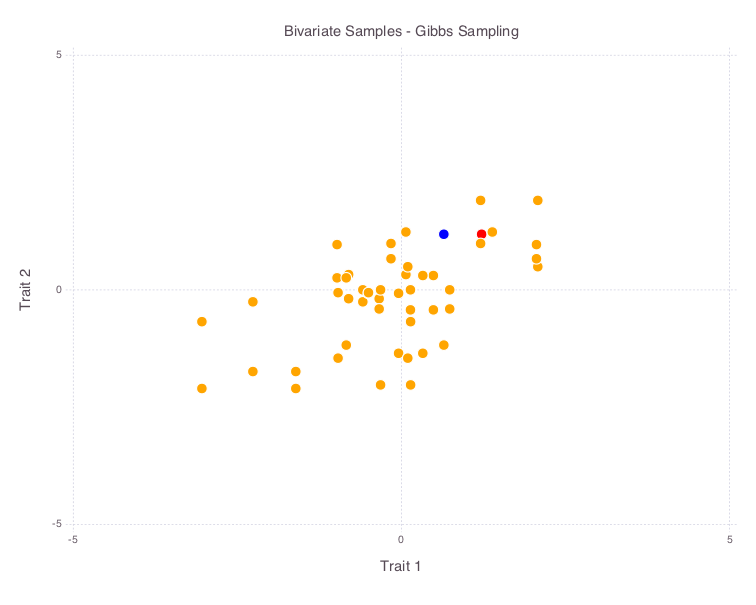

In [21]:
@manipulate for n=1:100        
    Gadfly.plot(
    y=gady1[1:(n-2)], x=gady2[1:(n-2)],
    Geom.point, 
    Guide.ylabel("Trait 2"),
    Guide.xlabel("Trait 1"),
    Guide.title("Bivariate Samples - Gibbs Sampling"),
    Theme(default_color=color("orange"),default_point_size=4pt),
    Scale.x_continuous(minvalue=-5, maxvalue=5),
    Scale.y_continuous(minvalue=-5, maxvalue=5),

    layer(y=[gady1[n-1]],x=[gady2[n-1]],
          Geom.point,
          Theme(default_color=color("blue"),default_point_size=4pt)),

    layer(y=[gady1[n]],x=[gady2[n]],
          Geom.point,
          Theme(default_color=color("red"),default_point_size=4pt))
    )
end

##<font color='blue'>Interactive Plotting for the Metropolis–Hastings algorithm </font>

In [16]:
m=[0.0 0.0]
v=[1.0 0.6
   0.6 1.0]

niter = 1000
nrow  = niter
ncol  = 2
ypair = Array(Float64,nrow,ncol);

y = zeros(1,2)
ynew = Array(Float64,1,2)
ycount = 0
xcount = 0
all_accepted_pairs=Array(Float64,nrow,2);
all_rejected_pairs=Array(Float64,nrow,2);
vi = inv(v)


m1 = 0;
m2 = 0;
xx = 0;
y1 = 0;
delta = 1.0;
min1 = -delta*sqrt(v[1,1]);
max1 = +delta*sqrt(v[1,1]);
min2 = -delta*sqrt(v[2,2]);
max2 = +delta*sqrt(v[2,2]);


lower_1 = m[1]-3*sqrt(v[1,1])
upper_1 = m[1]+3*sqrt(v[1,1])
lower_2 = m[2]-3*sqrt(v[2,2])
upper_2 = m[2]+3*sqrt(v[2,2])


ytmp=Array(Float64,nrow,4)
xtmp=Array(Float64,nrow,4)
naccept=0
nreject=0

z = (y-m)'
denOld = exp(-0.5*z'*vi*z); 

In [17]:
niter=1000
nrow=niter
recnum=Array(Int64,nrow,2)
points=Any[]
v3=zeros(3) # a vector as accepted or not / point x axis / point y axis

v3copy=copy(v3)
push!(points,v3copy)

for i=1:niter
    ynew[1] = y[1] + rand(Uniform(min1, max1))
    ynew[2] = y[2] + rand(Uniform(min2, max2))
    denNew  = exp(-0.5*(ynew-m)*vi*(ynew-m)');
    alpha   = denNew/denOld;    
    
    #create proposal interval
    xtmp[i,1]=y[1]+min1
    ytmp[i,1]=y[2]+min2
    xtmp[i,2]=y[1]+max1
    ytmp[i,2]=y[2]+min2    
    xtmp[i,3]=y[1]+min1
    ytmp[i,3]=y[2]+max2    
    xtmp[i,4]=y[1]+max1
    ytmp[i,4]=y[2]+max2
    
    #acceptance probability
    if rand()<alpha[1,1]   #Accept the new pair
       y[1] = ynew[1]
       y[2] = ynew[2] 
       denOld = exp(-0.5*(y-m)*vi*(y-m)'); 
       #naccept = naccept +1
       v3[1] = 1.0 
       #all_accepted_pairs[naccept,:]= y  
    else                  #Reject the new pair
       #nreject = nreject +1
       v3[1] = 0.0
       #all_rejected_pairs[nreject,:]= ynew   
    end
    
    v3[2]=ynew[1]
    v3[3]=ynew[2]
    v3copy=copy(v3)
    push!(points,v3copy)
end

In [18]:
numaccept=int(sum(points)[1])
numreject=niter+1-numaccept
all_accepted_pairs=Array(Float64,numaccept,2);
all_rejected_pairs=Array(Float64,numreject,2);
nreject=0
naccept=0
vecAccept=Int64[]

for i=1:niter
    if points[i][1]==0.0
       nreject += 1 
       all_rejected_pairs[nreject,:]= points[i][2:3]   
    else
       naccept += 1 
       all_accepted_pairs[naccept,:]= points[i][2:3]   
    end
    push!(vecAccept,naccept)
    
end

In [19]:
set_default_plot_size(20cm, 16cm)

Slider{Int64}([Input{Int64}] 500,"n",500,1:999)

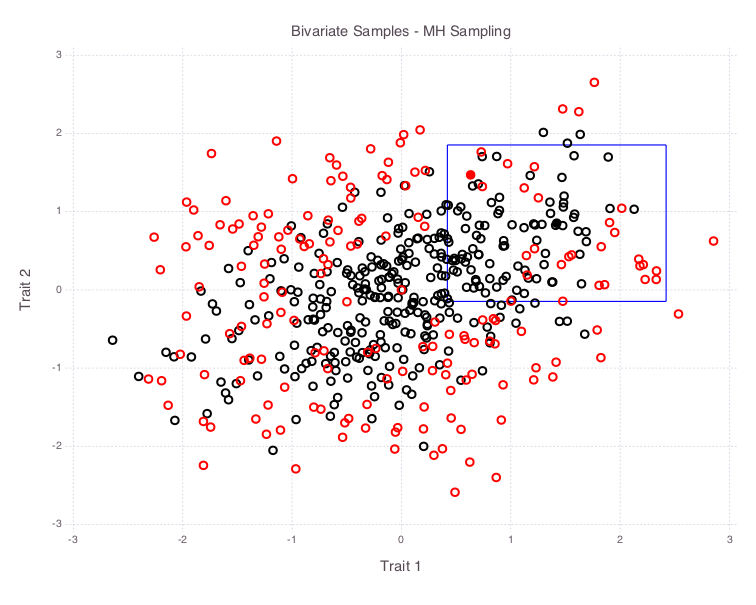

In [20]:
@manipulate for n=1:(niter-1)        
    Gadfly.plot(
    x=[points[n+1][2]],y=[points[n+1][3]], #proposal
    Geom.point,
    Scale.x_continuous(minvalue=-3, maxvalue=3),
    Scale.y_continuous(minvalue=-3, maxvalue=3),
    Theme(default_color=color("red"),default_point_size=4pt),
    Guide.ylabel("Trait 2"),
    Guide.xlabel("Trait 1"),
    Guide.title("Bivariate Samples - MH Sampling"),
    
    #current accepted point
    layer(x=[all_accepted_pairs[vecAccept[n],1]],y=[all_accepted_pairs[vecAccept[n],2]],
          Geom.point,
    Theme(default_color=color("black"),default_point_size=4pt)),
 
    #poroposal distribution
    layer(y=ytmp[n,1:2],x=xtmp[n,1:2],
          Geom.line,
          Theme(default_color=color("blue"),default_point_size=20pt)),    
    layer(y=ytmp[n,3:4],x=xtmp[n,3:4],
          Geom.line,
          Theme(default_color=color("blue"),default_point_size=20pt)),
    layer(y=ytmp[n,[1,3]],x=xtmp[n,[1,3]],
          Geom.line,
          Theme(default_color=color("blue"),default_point_size=20pt)),
    layer(y=ytmp[n,[2,4]],x=xtmp[n,[2,4]],
          Geom.line,
          Theme(default_color=color("blue"),default_point_size=20pt)),

    
    #layer(x=[all_accepted_pairs[1:vecAccept[n],1]],y=[all_accepted_pairs[1:vecAccept[n],2]],
    #     Geom.point,
    #Theme(default_color=color("black"),default_point_size=4pt)),
    
    #layer(x=[all_rejected_pairs[1:(n-vecAccept[n]),1]],y=[all_rejected_pairs[1:(n-vecAccept[n]),2]],
    #      Geom.point,
    #Theme(default_color=color("black"),default_point_size=4pt)),
    
    Guide.annotation(
       compose(context(), circle([all_rejected_pairs[1:(n-vecAccept[n-1]),1]], [all_rejected_pairs[1:(n-vecAccept[n-1]),2]],
       [1.0mm]), fill(nothing),
    stroke("red"))),
    
    Guide.annotation(
       compose(context(), circle([all_accepted_pairs[1:vecAccept[n-1],1]], [all_accepted_pairs[1:vecAccept[n-1],2]],
       [1.0mm]), fill(nothing),
    stroke("black")))
    )
end

##Appendix
Interact.jl works nicely with Jupyter notebook. To make interactive plotting in REPL (terminal), *Winston* is a better choice.

###Winston

In [10]:
using Winston

STDIN> a


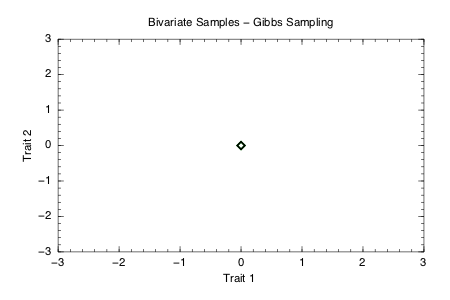

In [ ]:
p = FramedPlot(
         title="Bivariate Samples - Gibbs Sampling",
         xlabel="Trait 1",
         ylabel="Trait 2",
         xrange=(lower_1,upper_1),
         yrange=(lower_2,upper_2))

point1=Points(ypair[1,1],ypair[1,2],color="green")
point2=Points(ypair[1,1],ypair[1,2])
add(p,point1)

for iter=2:nrow
    readline(STDIN)
    point1=Points(ypair[iter-1,1],ypair[iter,2],color="green")
    add(p,point1,point2)
    display(p)
    point1=Points(ypair[iter-1,1],ypair[iter,2]) #change to black

    readline(STDIN)
    point2=Points(ypair[iter,1],ypair[iter,2],color="green")
    add(p, point1,point2)
    display(p)
    point2=Points(ypair[iter,1],ypair[iter,2]) #change to black
end;